In [1]:
# 시작점, 끝점을 하나의 넘파이로 합쳐놓기(테스트를 위해 시작점 2를 삽입없이 합치는 기능도 넣음)
def start_end_marge (end_point, start_point_1, start_point_2 = False):
    n = 2
    SE = np.array([])
    SE = np.append(SE, end_point)
    SE = np.append(SE, start_point_1)
    if (start_point_2 != False):
        SE = np.append(SE, start_point_2)
        n = 3
    SE = np.reshape(SE, (n, 2))
        
    return SE, n

# 랜덤 스팟 생성

In [2]:
def make_random_spot (input_spot, min_range, max_range, input_x, rseed=None):
    if(rseed != None):
        np.random.seed(rseed)
        
    var = ['X', 'Y']
    labels=['spot0']
    for i in range(0,input_spot-1):
        z = 'spot'+str(i+1)
        labels.append(z)
        
    # X를 사전에 만들어둔게 없으면 랜덤으로 만들어줌
    # 만들어둔게 있다면 X를 input_x에 입력받아서 데이터 프레임 만들 때 사용
    if len(input_x) == 0:
        X = (max_range - min_range) * np.random.random_sample([input_spot,2]) + min_range
    else:
        X = input_x
    df = pd.DataFrame(X, columns = var, index = labels)
    
    return labels, X, df

# 군집 + 덴드로그램 출력

In [3]:
def hierarchical_dendrogram(df, labels, input_spot=0, row_dist_print=False, a_print=False, dendrogram_print=False):
    
    distmatrix = pdist(df, metric = 'euclidean')
    row_dist = pd.DataFrame(squareform(distmatrix), columns = labels, index = labels)
    
    if(input_spot == 0):
        print('row_dist 반환')
        return row_dist
    
    row_clusters = linkage(distmatrix, method = 'complete')
    
    if(row_dist_print == True):
        print_col = row_dist.iloc[:5,:5]
        print(print_col)
        
    if(a_print == True):
        a=pd.DataFrame(row_clusters,
            columns=['클러스터ID_1', '클러스터ID_2', '거리', '클러스터 멤버수'],
            index = ['클러스터 %d' %(i+input_spot) for i in range(row_clusters.shape[0])])
        print(a[:5])
        
    if(dendrogram_print == True):
        plt.figure(figsize=(25,5))
        plt.subplot(121)
        plt.title('dendrogram')
        row_dendr = dendrogram(row_clusters, labels = labels)
        plt.tight_layout()
        plt.ylabel('euclide')
    
    return row_clusters

# 군집별 넘버링 함수 + 출력

In [4]:
def cluster_numbering(row_clusters, input_range):
    # 넘버링에 필요한 재귀함수
    def found_num(Num, count, h):
        # ↓이미 넘버링 끝났는지 확인(끝났으면 0이므로 탈출, 아니면 지금 넘버링 시작이니 0으로 지정)
        if(iHave[Num][3]==0):
            return -1
        else:
            iHave[Num][3] = 0
            
        # 왼쪽 자식 확인
        if(iHave[Num][0] < h):
            cluster_done[int(iHave[Num][0])] = count
        else: #재귀
            left = int(iHave[Num][0]) - h
            found_num(left,count,h)
            
        # 오른쪽 자식 확인
        if(iHave[Num][1] < h):
            cluster_done[int(iHave[Num][1])] = count
        else: #재귀
            right = int(iHave[Num][1]) - h
            found_num(right,count,h)
        return
    
    rc_len = len(row_clusters)
    for i in range(0, rc_len):
        if(row_clusters[i][2] > float(input_range)):
            iHave = row_clusters[:i,:]
            num = i - 1 #몇 번의 합치기가 되었는지 저장
            break
            
    # 빈 리스트를 군집 개수 만큼 생성
    h = rc_len + 1
    cluster_done = [-1 for _ in range(h)]
    
    
    # 재귀 함수 호출
    count = 1
    for i in range(num, -1, -1):
        cycle = found_num(i, count, h)
        if (cycle != -1):
            count += 1
    
    return cluster_done

# 군집별 중앙 값 검색(함수, 정렬, 중심찾기)

In [5]:
def quick_sort(centroid_X):
    def sort(low, high):
        if high <= low:
            return
        
        mid = partition(low, high)
        sort(low, mid - 1)
        sort(mid, high)
    
    def partition(low, high):
        pivot = centroid_X[(low + high) // 2][2]
        while low <= high:
            while centroid_X[low][2] < pivot:
                #print(centroid_X[low][2], low, pivot)
                low += 1
            while centroid_X[high][2] > pivot:
                high -= 1
            if low <= high:
                centroid_X[low][2], centroid_X[high][2] = centroid_X[high][2].copy(), centroid_X[low][2].copy()
                centroid_X[low][1], centroid_X[high][1] = centroid_X[high][1].copy(), centroid_X[low][1].copy()
                centroid_X[low][0], centroid_X[high][0] = centroid_X[high][0].copy(), centroid_X[low][0].copy()
                low, high = low + 1, high - 1
        return low
    
    return sort(0, len(centroid_X) - 1)

def marge_n_sort (input_spot, X, cluster_done):
    # 중앙 좌표 저장을 위한 numpy배열 생성(-1.0으로 모두 채움)
    centroid_X = np.full((input_spot, 3), -1.0)
    
    #스팟 좌표+소속 군집 번호
    for i in range(input_spot):
        centroid_X[i][0] = X[i][0]
        centroid_X[i][1] = X[i][1]
        centroid_X[i][2] = cluster_done[i]
    
    non_sort_centroid = centroid_X.copy()
    quick_sort(centroid_X)
    
    #노이즈 좌표 + 노이즈 번호(노이즈는 모두 -1)
    """for i in range(drop_len):
        non_sort_centroid = np.append(non_sort_centroid, (drop_list[i][0],drop_list[i][1],-1.0))
        centroid_X = np.append(centroid_X, (drop_list[i][0],drop_list[i][1],-1.0))"""
    
    non_sort_centroid = np.reshape(non_sort_centroid, (input_spot,3))
    centroid_X = np.reshape(centroid_X, (input_spot,3))
    
    return centroid_X, non_sort_centroid

In [6]:
def make_centroid(centroid_X):
    # 중심 좌표 계산
    count = 1
    sumx = sumy = 0.0
    centroid = np.array([])
    shape = 0
    
    for i in range(len(centroid_X)):
        if(centroid_X[i][2] == -1):
            continue
        
        sumx += centroid_X[i][0]
        sumy += centroid_X[i][1]
        count += 1
        if (i == len(centroid_X)-1) or (centroid_X[i][2] != centroid_X[i+1][2]):
            centroid = np.append(centroid, [sumx / float(count-1),sumy / float(count-1)])
            count = 1
            sumx = sumy = 0
            shape = int(centroid_X[i][2])
    
    centroid = np.reshape(centroid, (shape,2))
    
    return centroid

#  계층 군집되지 못한 노드들을 분리

In [7]:
def make_drop(new_X, new_cluster_done):
    drop_list = np.array([])
    drop_len = 0
    
    J = len(new_cluster_done)-1
    i = 0
    
    while True:
        if i >= J:
            break
        if new_cluster_done[i] == -1:
            del new_cluster_done[i]
            drop_list = np.append(drop_list, new_X[i])
            new_X = np.delete(new_X, i, axis = 0)
            drop_len += 1
            i -= 1
            J -= 1
        i += 1
    drop_list = drop_list.reshape(drop_len, 2)
    
    return new_X, drop_list, drop_len, new_cluster_done

In [8]:
def do_clustering(peoplenum):
    # 1 
    input_spot = peoplenum # ^^^^^^^^^^^^^ 터틀에서 생성한거 받아옴
    input_range = 20
    min_range = 0
    max_range = 200
        
    SE, SE_n = start_end_marge(end_point_1, start_point_1)
    
    
    # 2 랜덤 스팟 생성
    # 랜덤한 값을 받을거면 input_x 자리에 [] 입력하고 아니라면 X를 입력하면 됨 (seed == 111)
    # ^^^^^^^^^^^^^ 터틀에서 생성한거 받아옴(randeom_point)
    labels, X, df = make_random_spot(input_spot, min_range, max_range, np.array(random_point))
    
    # 3 군집 + 덴드로그램 출력
    row_clusters = hierarchical_dendrogram(df, labels, input_spot)
    
    # 4 군집별 넘버링 함수 + 출력
    cluster_done = cluster_numbering(row_clusters.copy(), input_range)
    
    plt.figure(figsize=(13,5))
    plt.subplot(121)
    plt.title('random_spots on graph')
    
    plt.scatter(X[:,0], X[:,1], c = 'blue', marker = 'o', s = 30)
    plt.grid(True)
    
    plt.subplot(122)
    plt.title('print clusters')
    plt.scatter(X[:,0], X[:,1], c=cluster_done, marker = 'o', s=30, cmap='tab20b', alpha = 0.8)
    plt.grid(True)
    
    plt.show()
    
    
    # 5 군집별 중앙 값 검색(함수, 정렬, 중심찾기)
    centroid_X, non_sort_centroid = marge_n_sort (input_spot, X, cluster_done)
    centroid = make_centroid(centroid_X)
    
    # 6 계층 군집되지 못한 노드들을 분리
    new_X, drop_list, drop_len, new_cluster_done = make_drop(X.copy(), deepcopy(cluster_done))
    
    # 7 최종 출력
    plt.figure(figsize=(13,5))
    
    plt.subplot(121)
    plt.title('print clusters and noise')
    plt.scatter(new_X[:,0], new_X[:,1], c=new_cluster_done, marker = 'o', s=30, cmap='tab20b', alpha = 0.8)
    plt.scatter(drop_list[:, 0], drop_list[:, 1], marker = 'x', s=40, color = 'black')
    plt.grid(True)
    
    plt.subplot(122)
    plt.title('print centroid')
    plt.scatter(new_X[:,0], new_X[:,1], c=new_cluster_done, marker = 'o', s=30, cmap='tab20b', alpha = 0.2)
    plt.scatter(drop_list[:, 0], drop_list[:, 1], marker = 'D', s=30, color = 'green', alpha = 0.5)
    plt.scatter(centroid[:,0], centroid[:,1], marker = 'D', s=30, color = 'red', alpha = 0.5)
    
    plt.grid(True)
    plt.show()
    # 8 cenoise (군집 중심 + 노이즈만 합친 넘파이)
    
    cenoise = np.append(drop_list, centroid)
    cenoise = np.reshape(cenoise, (drop_len+len(centroid),2))
    
    # cenoise에 시작점, 끝점 합침
    cenoise = np.append(cenoise, SE)
    cenoise = np.reshape(cenoise, (drop_len+len(centroid)+SE_n,2))
    
    # 9 coordinate_1 (각 스팟의 이동해야할 위치 배열 저장)
    coordinate_1 = np.array([])
    for i in range(len(non_sort_centroid)):
        n = int(non_sort_centroid[i][2])
        if(n != -1):
            coordinate_1 = np.append(coordinate_1, centroid[n-1].copy())
        else:
            coordinate_1 = np.append(coordinate_1, non_sort_centroid[i][:2].copy())
    coordinate_1 = np.reshape(coordinate_1, (input_spot,2))
    #print(coordinate_1)

[[127.04782984, 37.501171129999996], [127.03777086000001, 37.501880645], [127.03318084, 37.499515595], [127.03552468000001, 37.49675637], [127.04167726, 37.501171129999996], [127.04802516000001, 37.49943676], [127.03738022, 37.50590123], [127.04294684, 37.509764145], [127.03484106, 37.507872105], [127.0420679, 37.505191715]]


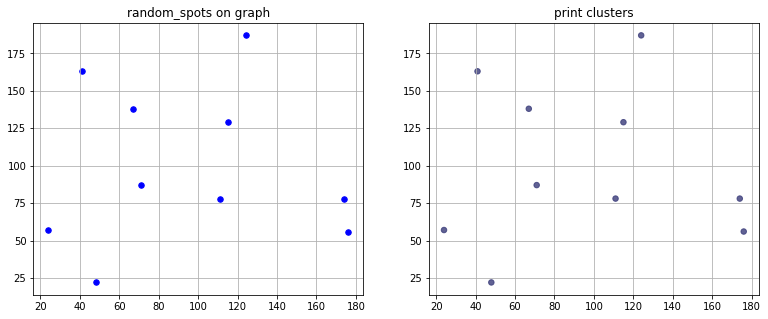

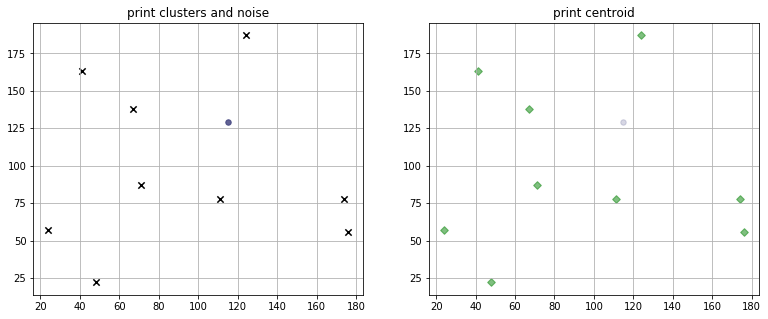

[[174.  78.]
 [ 71.  87.]
 [ 24.  57.]
 [ 48.  22.]
 [111.  78.]
 [176.  56.]
 [ 67. 138.]
 [124. 187.]
 [ 41. 163.]
 [115. 129.]]


Exception in Tkinter callback
Traceback (most recent call last):
  File "D:\anaconda\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "<ipython-input-9-799fb80f1814>", line 78, in quit
    turtle.done()
  File "<string>", line 5, in mainloop
turtle.Terminator


In [9]:
import turtle
import tkinter
import random
import numpy as np
import requests as r
import json

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from tqdm import tqdm
from copy import deepcopy

names=[] #사람 터틀 배열
random_point=[]#랜덤 좌표
trans_p=[]#위도경도

#yeji
min_range = 0
max_range = 200
start_point_1=(max_range - min_range) * np.random.random_sample(2) + min_range
end_point_1=(max_range - min_range) * np.random.random_sample(2) + min_range
#yeji

http_header = {
    'user-agent': 'Mozilla/5.0 (iPhone; CPU iPhone OS 11_0 like Mac OS X) AppleWebKit/604.1.38 (KHTML, like Gecko) Version/11.0 Mobile/15A372 Safari/604.1',
    'x-requested-with': 'XMLHttpRequest'
}
session = r.Session()
session.headers.update(http_header)
search_distance_url_base = 'https://m.map.naver.com/spirra/findCarRoute.nhn?route=route3&output=json&result=web3&coord_type=latlng&search=2&car=0&mileage=12.4'
def SEARCH_DISTANCE_URL(start_point, end_point):
    return search_distance_url_base+'&start={}&destination={}'.format(start_point, end_point)

def SEARCH_POINT_URL(q):
    
    return 'https://m.map.naver.com/apis/search/poi?query={}&page=1'.format(q)

def GET_INFO(x,y,x1,y1):#거리 계산
    start_point = '{},{}'.format(x, y)
    end_point = '{},{}'.format(x1, y1)
    res = session.get(SEARCH_DISTANCE_URL(start_point, end_point)).text
    res_dict = json.loads(res)
    target = res_dict['routes'][0]['summary']
    distance = target['distance']
    return distance/1000

def people2(a):#입력받은수만큼 객체를 추가하고  랜덤위치로 세팅
    names.append(turtle.Turtle())
    random_point.append([random.randint(0,200),random.randint(0,200)])
    speed=0
    names[a].speed(speed)
    names[a].penup()
    
    names[a].setpos(random_point[a][0],random_point[a][1])
    names[a].pendown()

def people3():#생성버튼을 누르면 실행되는 함수 여기서 people2함수를 입력받은수 만큼 실행
    del names[:]
    del random_point[:]
    del trans_p[:]
    turtle.clearscreen()
    setting()
    peoplenum=int(entry_formula.get())
    turtle.tracer(peoplenum)
    for i in range(0,peoplenum):
        people2(i)
    trans_point(peoplenum)
    
    

def quit():#종료눌렀을때 실행 조금 수정할 필요있음
    window.destroy()
    turtle.bye()
    turtle.done()

def setting():#초기 세팅
    setting_t=turtle.Turtle()
    setting_t.speed(0)
    setting_t.penup()
    setting_t.hideturtle()
    setting_t.setpos(0,-10)
    setting_t.pendown()
    setting_t.setpos(0,200)
    setting_t.penup()
    setting_t.setpos(-10,0)
    setting_t.pendown()
    setting_t.setpos(200,0)
    turtle.bgpic("1t.gif")#지도

def cluster():
    peoplenum=int(entry_formula.get())
    do_clustering(peoplenum) # yeji's made
    '''turtle.tracer(1)
    count = int(len(names)/2)
    for j in range(count):
        names[j].color('skyblue')
    for j in range(len(names)-1,count-1,-1):
        names[j].color('pink')'''
        
def center():
    cul_point=[]
    cul_point.append(turtle.Turtle())
    cul_point.append(turtle.Turtle())
    turtle.tracer(2)
    cul_point[0].shape('square')
    cul_point[0].penup()
    cul_point[0].color('blue')
    cul_point[0].setpos(60,30)
    
    cul_point[1].shape('square')
    cul_point[1].penup()
    cul_point[1].setpos(50,70)
    cul_point[1].color('red')
    
def move():
    count = int(len(names)/2)
    turtle.tracer(1)
    for j in range(count):
        names[j].setpos(60,30)
    for j in range(len(names)-1,count-1,-1):
        names[j].setpos(50,70)


def start():
    bus=[]
    dis_1=0
    dis_2=0
    dis_3=0
    distance=0
    text=''
    point=turtle.Turtle()
    point.speed(0)
    point.penup()
    point.setpos(start_point_1[0],start_point_1[1])
    point.dot(30,'blue')
    point.write('start_point_1')
    point.setpos(end_point_1[0],end_point_1[1])
    point.dot(30,'red')
    point.write('end_point_1')
    point.hideturtle()
    
    bus.append(turtle.Turtle())
    bus[0].speed(0)
    bus[0].shape('turtle')
    bus[0].penup()
    bus[0].setpos(start_point_1[0],start_point_1[1])
    
    
    dis_1=bus[0].distance(60,30)
    bus[0].speed(3)
    bus[0].pensize(5)
    bus[0].pendown()
    bus[0].setpos(60,30)
    
    dis_2=bus[0].distance(50,70)
    
    bus[0].setpos(50,70)
    bus[0].setpos(end_point_1[0],end_point_1[1])
    dis_3=bus[0].distance((50,70))
    distance=dis_1+dis_2+dis_3
    text='이동 거리 : %d 입니다.' % (distance)
    bus[0].write(text,font=15)

def superbt():
    people3()
    cluster()
    center()
    move()
    start()
def trans_point(a):#랜덤좌표를 위도 경도로
    x=127.030837
    y=37.495022
    for i in range(0,a):
        trans_p.append([x+random_point[i][0]*0.00009766,y+random_point[i][1]*0.000078835])
    print(trans_p)#위경도 출력
    
turtle.screensize(1000,1000)  
turtle.setup(1000,1000,0,0)
turtle.setworldcoordinates(-10,-10,200,200)#터틀 좌표 설정 -10~200
#turtle.setup(1500,1200)


setting()
turtle.title("최적경로 알로리즘 시뮬레이션")



window=turtle.getcanvas() #터틀과  tkinter을 연결하기위한 윈도우

frame_title=tkinter.Frame(window) 

frame_title.grid(row=1, column=0, padx=10, pady=10)

produce_bottom = tkinter.Frame(window)#생성버튼
produce_bottom.grid(row=2, column=0)

cluster_bottom = tkinter.Frame(produce_bottom)#군집버튼
cluster_bottom.grid(row=0, column=4)


center_bottom = tkinter.Frame(produce_bottom)#중심버튼
center_bottom.grid(row=0, column=6)

move_bottom = tkinter.Frame(produce_bottom)#이동버튼
move_bottom.grid(row=0, column=8)

bus_bottom = tkinter.Frame(produce_bottom)#버스버튼
bus_bottom.grid(row=0, column=10)




reset_bottom = tkinter.Frame(produce_bottom)#리셋버틍
reset_bottom.grid(row=0, column=12)



exit_bottom = tkinter.Frame(produce_bottom)#종료버튼
exit_bottom.grid(row=0, column=14)

super_bottom= tkinter.Frame(produce_bottom)#슈퍼버튼
super_bottom.grid(row=0, column=16)

entry_formula = tkinter.Entry(produce_bottom, width=20)#숫자입력받는 칸
entry_formula.grid(row=0, column=1, padx=10, pady=10)

tkinter.Button(produce_bottom, text='생성', command=people3).grid(row=0, column=2)#버튼누를시 command 함수 실행
tkinter.Button(cluster_bottom, text='군집', command=cluster).grid(row=0, column=3)
tkinter.Button(center_bottom, text='중심', command=center).grid(row=0, column=3)
tkinter.Button(move_bottom, text='이동', command=move).grid(row=0, column=3)
tkinter.Button(bus_bottom, text='버스', command=start).grid(row=0, column=3)
tkinter.Button(reset_bottom, text='리셋', command=turtle.clearscreen).grid(row=0, column=4)
tkinter.Button(exit_bottom, text='종료', command=quit).grid(row=0, column=5)
tkinter.Button(super_bottom, text='슈퍼', command=superbt).grid(row=0, column=6)


turtle.done()